1/1 [==============================] - ETA: 0s

c:\ProgramData\anaconda3\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 91ms/step


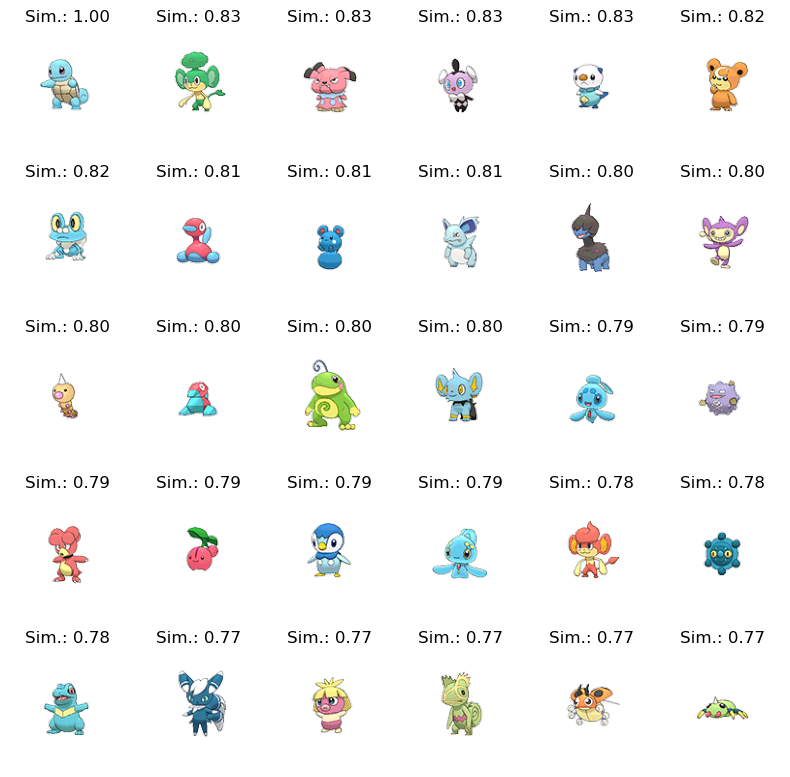

In [4]:
import numpy as np
from os import path
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Pokémon 데이터 불러오기
df = pd.read_csv("./pokemon/pokemon.csv") # 경로변경 #

# 이미지 특징 추출 클래스
class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        img = img.resize((224, 224))
        img = img.convert('RGB')
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

# 이미지 특징 추출기 초기화
fe = FeatureExtractor()

# 이미지 특징과 경로 저장할 리스트 초기화
img_paths = []
features = []

# Pokémon 이미지 특징 추출 및 경로 저장
for i in df['Name']:
    image_path = f"./pokemon/images/images/{i}.png"
    if not path.exists(image_path):
        image_path = f"./pokemon/images/images/{i}.jpg"
    img = Image.open(image_path)
    feature = fe.extract(img)
    img_paths.append(image_path)
    features.append(feature)

# 쿼리 이미지의 특징 추출
query_image_path = "./pokemon/images/images/squirtle.png" # 이미지 경로변경 #
query = fe.extract(Image.open(query_image_path))

# 유사도 계산 (코사인 유사도)
cosine_sims = cosine_similarity(features, [query])

# 유사한 이미지 찾기
similar_indices = np.argsort(cosine_sims, axis=0)[::-1][:30]

# 결과를 시각화
axes = []
fig = plt.figure(figsize=(8, 8))
for a in range(5 * 6):
    index = similar_indices[a][0]
    score = cosine_sims[index][0]
    image_path = img_paths[index]
    axes.append(fig.add_subplot(5, 6, a + 1))
    subplot_title = f"Sim.: {score:.2f}"
    axes[-1].set_title(subplot_title)
    plt.axis('off')
    plt.imshow(Image.open(image_path))

fig.tight_layout()
plt.show()
